Normal Distribution: In Code
------


In [1]:
reset -fs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

sns.set_style("white")
%matplotlib inline

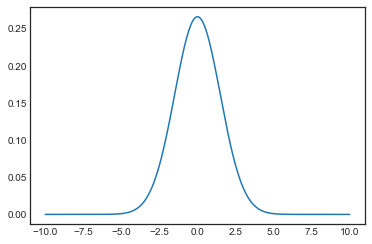

In [3]:
x = np.linspace(start=-10, stop=10, num=1000)
y = stats.norm.pdf(x, loc=0, scale=1.5) 
plt.plot(x, y);

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("bimodal_example.csv")
df.head(n=5)

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


In [6]:
data = df.x

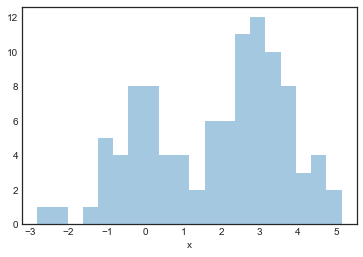

In [7]:
sns.distplot(data,
             bins=20,
             kde=False);

Is the normal distribution a useful model for the data?

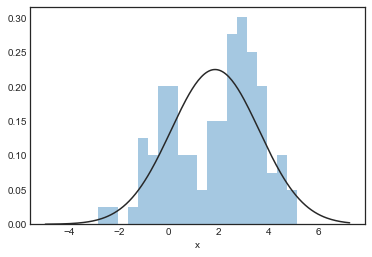

In [8]:
sns.distplot(data,
             fit=stats.norm,
             bins=20,
             kde=False,);

<br>
<br> 
<br>

----
Define The Model
-----

Two Normal distributions $N(\mu_1, \sigma_1^2)$ and $N(\mu_2, \sigma_2^2)$. 

There are 5 paramaters: 4 of the them are Normal distributions and 1 more for the probability of choosing one of them.

Let $w$ be the probability that the data comes from the first Normal, the parameter in this model is $\theta = (w, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2)$.

The probability density function (PDF) is:

$$f(x | \theta) = w \  f_1(x \ | \  \mu_1, \sigma_1^2) + (1 - w) \  f_2 (x  \ | \  \mu_2, \sigma_2^2) $$  

Fit The Model
-----

Expectation–Maximization (EM) Algorithm  
-----
<br>
<center><img src="http://www.wilsonmongwe.co.za/wp-content/uploads/2015/07/400px-EM.jpg" width="400"/></center>

What is Expectation–Maximization (EM) algorithm?
------

An iterative method for finding maximum likelihood (MLE) or maximum a posteriori (MAP) estimates of parameters in statistical models,when the model depends on unobserved latent variables

Expectation–Maximization (EM) Workflow
------
<br>
<center><img src="http://people.revoledu.com/kardi/tutorial/EM/images/EM_algorithm.png" width="500"/></center>

Alternates between performing:

- __Expectation (E)__ step: Given the current parameters of the model, estimate a probability distribution.

- __Maximization (M)__ step: Given the current data, estimate the parameters to update the model.

EM, more formally
-----

Alternates between performing:

- __Expectation (E)__ step: Using the current estimate for the parameters, create function for the expectation of the log-likelihood.  

- __Maximization (M)__ step: Computes parameters maximizing the expected log-likelihood found on the E step. 

The M parameter-estimates are then used to determine the distribution of the latent variables in the next E step.

A kinder, _softer_ k-means
-----

A “soft" version of $k$-means. 

Instead of assigning each point to just one cluster (hard clustering), EM will attach a probability to the membership of a point in each cluster - P(cluster|point). 

A data point can thus belong to several clusters (though with different probabilities).

EM is trying to maximize the following function:
------
    
<center><img src="images/em_form.png" width="500"/></center>

- X is directly observed variable
- θ parameters of model
- Z is not directly observed / latent variable
    - Z is a joint (related) distribution on x.

Check for understanding
------

When do stop alternating between E & M?

<br>
<details><summary>
Click here for the solution…
</summary>
- Convergence (no _significant_ improvement)  
- We hit a priori stopping criteria  
- We run out of budget (time or money)  
</details>

EM Steps
-----

1. Initialize the parameters θ
2. Compute the best values for Z given θ  
3. Use the computed values of Z to compute a better estimate for the θ  
4. Iterate steps 2 and 3 until convergence

EM steps, stated another way
-----

1. Initialize the parameters of the models, either randomly or doing a "smart seeding"

2. E Step: Find the posterior probabilities of the latent variable given current parameter values.

3. M Step: Reestimate the parameter values given the current posterior probabilities.

4. Repeat 2-3 monitoring the likelihood function likelihood. Hope for convergence.

<br>
<details><summary>
Click here for the solution…
</summary>
The centers of the clusters. <br>
<br>
The centers of the clusters are new / missing / latent variables.
</details>

Back to our data
-----



In [9]:
class Gaussian:
    "Model univariate Gaussian"

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y

    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [10]:
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

Best single Gaussian: μ = 1.9, σ = 1.8


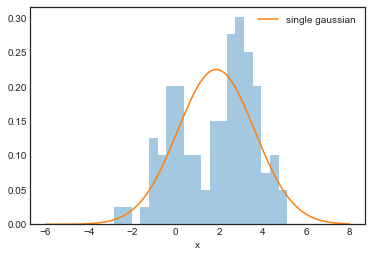

In [11]:
x = np.linspace(-6, 8, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [12]:
from math import sqrt, log, exp, pi
from random import uniform

In [34]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            print('W1 =', wp1)
            print('W2 =', wp2)
            yield (wp1, wp2)
        print('***********************************************************************************')
    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)
        print('##################################################################################')

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep())
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

HT: https://gist.github.com/kylebgorman/2992206

In [35]:
# Check out the fitting process
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

W1 = 3.932025369722457e-68
W2 = 1.0
W1 = 4.683286549965977e-153
W2 = 1.0
W1 = 0.9999999999999977
W2 = 2.414847461554324e-15
W1 = 0.41291757737462575
W2 = 0.5870824226253744
W1 = 1.3276437953446566e-133
W2 = 1.0
W1 = 0.9999999999999771
W2 = 2.2936799568439925e-14
W1 = 8.491055487088212e-52
W2 = 1.0
W1 = 0.999983513025234
W2 = 1.6486974765982477e-05
W1 = 0.9999999999999974
W2 = 2.6087189278235506e-15
W1 = 0.9999999999999148
W2 = 8.517426359106417e-14
W1 = 0.9999992154897771
W2 = 7.845102228373185e-07
W1 = 7.16053638552882e-53
W2 = 1.0
W1 = 0.7618751207428426
W2 = 0.2381248792571574
W1 = 0.9999999999999946
W2 = 5.393868465166763e-15
W1 = 1.6220026895288156e-26
W2 = 1.0
W1 = 5.87598378856312e-70
W2 = 1.0
W1 = 0.9999999984075788
W2 = 1.5924210844564236e-09
W1 = 2.99585060964602e-80
W2 = 1.0
W1 = 0.9999999999999968
W2 = 3.2801931426136177e-15
W1 = 5.035614536225007e-47
W2 = 1.0
W1 = 0.0034423152389810715
W2 = 0.9965576847610188
W1 = 2.854525798041788e-139
W2 = 1.0
W1 = 2.25086068332092e-106


In [21]:
mix = GaussianMixture(data)


In [26]:
mix.one
mix.two
uniform(1, 2)

1.8528924356011394

In [24]:
# Check out the fitting process
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

 1 Mixture: Gaussian(-0.579471, 0.721245), Gaussian(2.68444, 1.1538), mix=0.252)
 1 Mixture: Gaussian(-0.460951, 0.781235), Gaussian(2.73928, 1.13162), mix=0.274)
 1 Mixture: Gaussian(-0.396455, 0.805841), Gaussian(2.7992, 1.08213), mix=0.293)
 1 Mixture: Gaussian(-0.349001, 0.821726), Gaussian(2.85231, 1.03241), mix=0.309)
 1 Mixture: Gaussian(-0.309576, 0.836163), Gaussian(2.89537, 0.990736), mix=0.322)


In [15]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

Computing best model with random restarts...



Done. 🙂


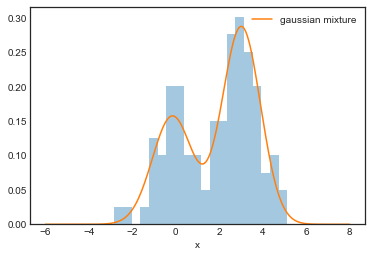

In [16]:
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();

GMM extensions: Beyond 2 Gaussians
-----

<center><img src="images/triples.jpg" width="700"/></center>

GMM extensions: Beyond 1 dimension
-----

<center><img src="images/em_2d_gmm.png" width="700"/></center>

Beyond GMM: Kernel Density Estimation (KDE)
-----

A non-parametric way to estimate the probability density function of a random variable.

We assume samples are drawn from some distribution with an unknown density ƒ.

Try to estimate with:
<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/15255412d35488194b7e24e4518765e0af9992b5" width="700"/></center>

The only parameter is h the "bandwidth".

It is non-parameter because the number of parameters does not increase with model complexity.

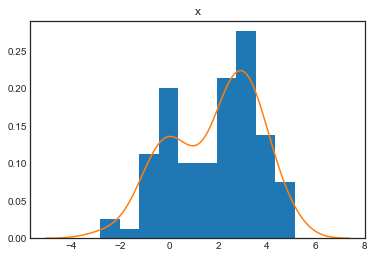

In [17]:
# Our data
df.hist(grid=False,
        normed=True);
sns.kdeplot(data,
           legend=False);

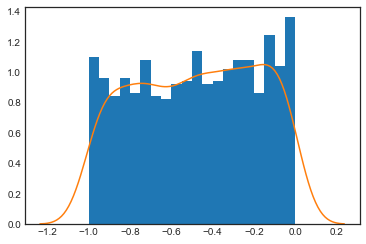

In [18]:
# Model an uniform without any priors
s = np.random.uniform(low=-1,
                      high=0,
                      size=1000)
plt.hist(s, bins=20, normed=True)
sns.kdeplot(s,
           legend=False);

Summary
----

- Gaussian Mixture Models (GMM) take our old friend the Gaussian and add another Gaussian(s).
- This allows us to model more complex data.
- We fit a GMM with the Expectation–Maximization (EM) Algorithm.
- Expectation–Maximization (EM) Algorithm is a series of steps to find good parameter estimates when there are latent variables.
- EM steps:
    1. Initialize the parameter estimates
    2. Given the current parameter estimates, find the min log likelihood for Z (data+latent variables)
    3. Given the current data, find better parameter estimates
    3. Repeat steps 2 & 3
- EM can be used beyond GMM
- GMM work well but you have to guess the number of Gaussians. Kernel Density Estimation (KDE) does __not__ require that kind of guessing 

Going Further...
----

- [mathematicalmonk's video series on the subject](https://www.youtube.com/playlist?list=PLD0F06AA0D2E8FFBA)
- [EM Demystified- An Expectation-Maximization Tutorial](https://www2.ee.washington.edu/techsite/papers/documents/UWEETR-2010-0002.pdf)
- [scikit-learn's implementation of GMM](http://scikit-learn.org/stable/modules/mixture.html) 

In [27]:
coordinate = ['x', 'y', 'z']
value = [3, 4, 5, 0, 9]

result = zip(coordinate, value)
resultList = list(result)
print(resultList)

c, v =  zip(*resultList)
print('c =', c)
print('v =', v)

[('x', 3), ('y', 4), ('z', 5)]
c = ('x', 'y', 'z')
v = (3, 4, 5)


<br>
<br> 
<br>

----